# Venn Tree Scanner prototype

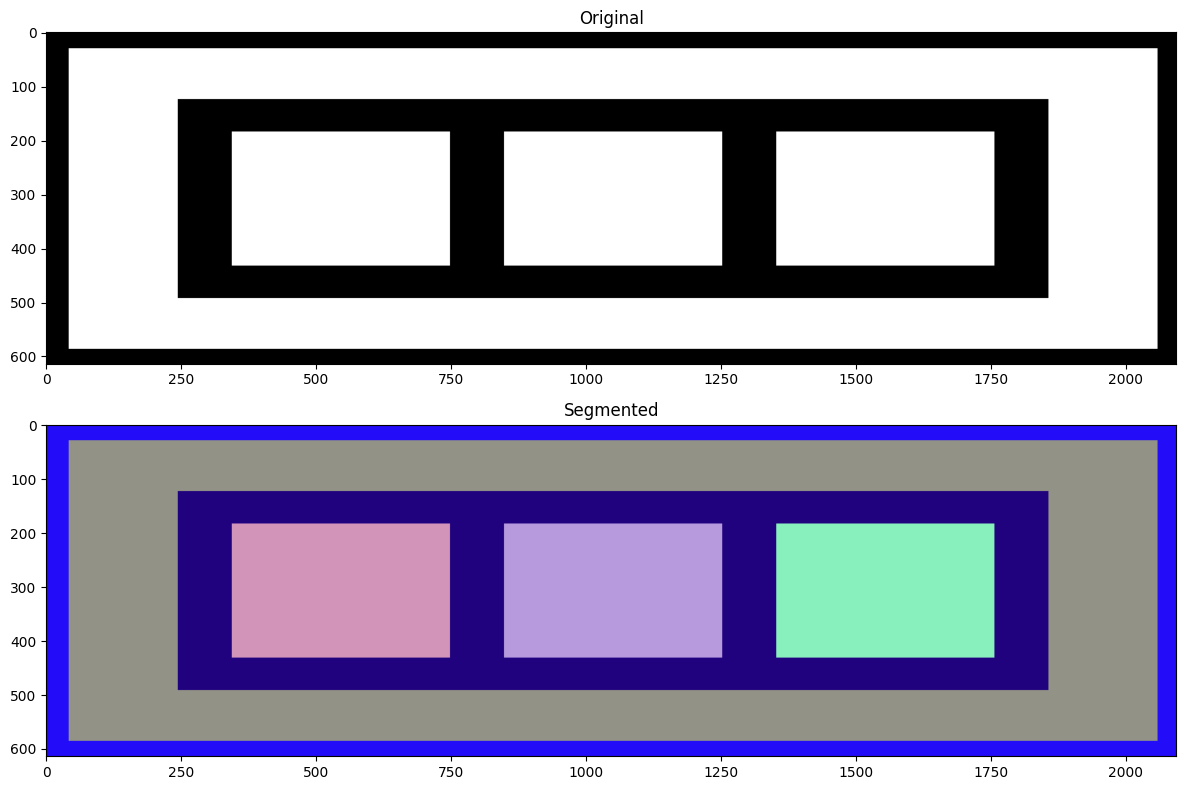

Image dimensions (y,x): (614, 2094)
# Classes: 6


In [5]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import skimage
from skimage.color import rgb2gray
from skimage import filters

def color_eq(c1, c2):
    return all(c1 == c2)

def color_close(c1, c2, tolerance=.4):
    #dist = np.sum((np.array(c1[:3] - c2[:3], dtype=float))**2)
    dist = np.linalg.norm(c1[:3]-c2[:3])
    # We are using RGB. Max distance is black vs white, 255
    # Therefore the max euclidean distance is:
    # sqrt((255^2)*3) = sqrt(195,075) = 441.673
    rel_dist = dist / 441.673
    assert rel_dist <= 1

    return rel_dist < tolerance

def show(original, segmented):
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    ax = axes.ravel()
    ax[0].imshow(original, cmap='gray')
    ax[0].set_title("Original")
    ax[1].imshow(segmented)
    ax[1].set_title("Segmented")
    fig.tight_layout()
    plt.show()

# original = io.imread("examples/helloworldblurred.png", as_gray=True)
original = io.imread("examples/base.png", as_gray=True)

# Apply Otsu's tresholding
threshold_value = filters.threshold_otsu(original)
original = original > threshold_value

##################################### 
### Segmenting image
##################################### 

# Create a matrix with the same size as the 
# original image, then color-segment the image
# assigning an incrementally new number to each
# segment. 
segmented = np.zeros(original.shape[:2], dtype=int)
max_x_diff = np.array([0], dtype=int)
cols = np.zeros((original.shape[0], original.shape[1], 4))

last_class_used = 0
for y in range(segmented.shape[0]):
    for x in range(segmented.shape[1]):
        if segmented[y][x] == 0:
            # New class!
            last_class_used += 1
            last_color_used = np.random.rand(4,)
            last_color_used[3] = 1

            left_most_x = 0
            right_most_x = 0

            segmented[y][x] = last_class_used
            cols[y][x] = last_color_used
            frontier = set([(y,x)])
            while len(frontier) > 0:
                pixpos = frontier.pop()
                left_most_x = min(left_most_x, pixpos[1])
                right_most_x = max(right_most_x, pixpos[1])
                for dx in [-1,0,1]:
                    for dy in [-1,0,1]:
                        ppy = pixpos[0]+dy
                        ppx = pixpos[1]+dx
                        if (ppy >= 0 and ppy < segmented.shape[0] and 
                            ppx >= 0 and ppx < segmented.shape[1] and
                            segmented[ppy,ppx] == 0 and # excluding also the pixel under analysis
                            #color_eq(original[pixpos[0]][pixpos[1]],original[ppy][ppx])):
                            # color_close(original[y][x],original[ppy][ppx])):
                            original[y][x] == original[ppy][ppx]): # Thresholded
                            segmented[ppy][ppx] = last_class_used
                            cols[ppy][ppx] = last_color_used
                            frontier.add((ppy,ppx))

            max_x_diff = np.append(max_x_diff, right_most_x - left_most_x)

# original = original[:,:,:3]
# grayscale = rgb2gray(original)
# imgY, imgX = grayscale.shape # scikit uses [Y, X, Channel] representation
# img = np.repeat(grayscale[:, :, np.newaxis], 3, axis=2) # Duplicating grayscale

show(original, cols)
print(f"Image dimensions (y,x): {segmented.shape}")
print(f"# Classes: {last_class_used}")

In [6]:
import sys
sys.path.append('../')
from tree.tree import TreeNode

num_classes = last_class_used+1
nodes = [TreeNode(children=[]) for _ in range(num_classes)]
classes_img = np.copy(segmented)
for y in range(classes_img.shape[0]):
    for x in range(classes_img.shape[1]):
        current_class = classes_img[y][x]
        for (dx, dy) in [(-1,-1),(1,0),(0,1),(-1,0),(0,-1),(1,1),(-1,1),(1,-1)]:
            ppy = y+dy
            ppx = x+dx

            if (ppy >= 0 and ppy < classes_img.shape[0] and 
                ppx >= 0 and ppx < classes_img.shape[1]):
                neighbour_class = classes_img[ppy][ppx]
                if (current_class != neighbour_class):
                    if max_x_diff[current_class] > max_x_diff[neighbour_class]:
                        parent = nodes[current_class]
                        child = nodes[neighbour_class]
                    else:
                        parent = nodes[neighbour_class]
                        child = nodes[current_class]
                    
                    if child not in parent.children:
                        parent.children.append(child)

root = nodes[np.argmax(max_x_diff)]   

root

[[[[], [], []]]]